# Application de methodes de traitement automatique d'image à un fonds photographique d'archives historique

## Du pixel aux images - 32M7138

*Printemps 2025 - Université de Genève*

*Raphaël Rollinet (raphael.rollinet@unine.ch)*

## Introduction

Ce Markdown effectué dans le cadre du cours "Du pixel aux images : introduction au traitement des images 2D" traite de méthodes utilisant de l'intelligence artificiel que cela soit avec des modèles de deep learning ou un LLM multimodale appliqué au traitement de l'image, plus précisément de la détection d'objet sur un fonds d'images anciennes. Mon travail vise à tester différente méthode et à analyser les résultats optenu afin d'en faire la critique du point de vue d'un archiviste.

### Méthode de détection d'objet

La méthode utilisée dans le cadre de ce projet sont un mélanges de méthodes de deep learning pour le traitement d'image. Pour être exactes les méthodes fonctionnent en mode inférence uniquement, et exploitent des poids figés issus de l’entraînement supervisé de grands corpus d’images. Leurs spécifications sont les suivantes :

#### Détection d’objets par SSD MobileNet v2 (TensorFlow Hub) :
Le modèle utilise une architecture Single Shot MultiBox Detector (SSD) avec un backbone MobileNetV2 optimisé pour les environnements à faibles ressources. SSD génère un ensemble de boîtes candidates (anchors) à différentes échelles et positions dans l’image, puis prédit pour chacune une probabilité de présence d’objet et une régression de boîte englobante. Le modèle a été préalablement entraîné sur COCO dataset, ce qui permet une détection multi-classes directement en inférence.

#### Classification d’image par ViT (Vision Transformer) :
Le modèle ViT Base (patch16-224) repose sur une adaptation des transformeurs à la vision par un découpage de l’image en patchs de 16x16, qui sont ensuite linéarisés et projetés en embeddings. Ces vecteurs sont enrichis par des encodages positionnels et traités par plusieurs couches transformeurs (self-attention). Le modèle prédit une seule classe globale pour l’image en sortie du token [CLS]. Il est pré-entraîné sur ImageNet-21k puis fine-tuné sur ImageNet-1k.

### Fonds d'images de la commune de Milvignes

Les modèles de détections et classifications des images sera appliqués à un fonds d'images provenant de l'inventaire des archives de la commune de Milvignes, membre du service intercommunal d'archives de Neuchâtel, la plateforme de diffusion des inventaires est gérée par docuteam SA, entreprise de gestion d'archives qui m'a employé de 2016 à 2021. Les images numérisées par mes soins en format de conservation (TIFF) et archivées électroniquement dans un repository de préservation numérique et également disponible  disponible en téléchargement librement dans un format dégradé de diffusion (JPEG).

![inventaire.png](attachment:inventaire.png)

Les images sont disponibles ici : https://milvignes.docuteam.cloud/fr/units/1-archives-communales-de-milvignes-1326-2013/gallery



## Problématique

Ayant longuement travaillé dans le domaine des archives, la thématique d'appliquer les méthodes vues dans le cadre de ce cours sur un fonds d'archives est un sujet intéressant dans son potentiel d'application sur un fonds d'archives d'images. Dans les institutions patrimoniales, les images sont un support courant, ma problématique sera donc appliquée à un fonds ancien d'images numérisées de la commune de Milvignes (NE). Mon questionnement porte sur l'application de cette méthode utilisant des modèles de deep learning entrainé sur des images relativement récentes, mais ici appliqué à un fonds d'images anciennes (~1900).

### Question de recherche

- "Quel est le potentiel de la détection d'objet dans le traitement, particulièrement pour la description de fonds d'images en archives ?"

## Méthodologie

Le code utilisé est adapté du code vu en cours, il vise à effectuer une détection d'objet sur des images, tout en répondant à des contraintes métiers qui sont par exemple un besoin d'automatiser le traitement à partir d'un workflow. Mais également en termes de rendu, un archiviste aura besoin d'extraire les détections sous format CSV afin qu'elles soient intégrées aux notices d'un système d'information archivistique par exemple sous la forme d'une indexation. Le code permet à n'importe quel archiviste avec des notions informatiques minimales de l'exécuter.

In [1]:
#Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Installation des librairies (si nécessaire)
!pip install opencv-python
!pip install tensorflow_hub
!pip install -q transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Importation des librairies Python
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
# Charger les modèles (détection + classification)

# Modèle de détection SSD MobileNet V2
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1")

# Modèle ViT pour classification d'image
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [ ]:
# Liste des noms de classes (80 classes COCO)
classe = np.array([
    'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
])
classes = np.concatenate([classe, np.repeat('none', 100)])


In [ ]:

# [Alternative]

# Liste des noms de classes adaptée au 19e-20e siècle en Suisse, incluant les moyens de transport
classe = np.array([
    'background', 'person', 'horse', 'bird', 'cat', 'dog', 'sheep',
    'cow', 'bench', 'backpack', 'umbrella', 'handbag', 'bottle',
    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'chair',
    'couch', 'bed', 'dining table', 'book', 'clock', 'vase', 'scissors',
    'train', 'boat', 'carriage'  # Ajout des moyens de transport pertinents
])

# Ajout de 'none' pour atteindre la longueur souhaitée
classes = np.concatenate([classe, np.repeat('none', 88)])


In [ ]:
#  À adapter : Mettre le dossier Images dans Google Drive
folder_path = "/content/drive/MyDrive/Colab_Notebooks/images"  # Adapter le chemin selon l'utilisateur

In [ ]:
# Liste pour stocker les résultats
results = []

In [ ]:
# Création d'une fonction de detection et classification pour le traitement de l'image
## Traite une image avec SSD MobileNet (détection) et ViT (classification).
## Sauvegarde l'image annotée et stocke les résultats dans la liste globale 'results'.

def process_image_with_detection_and_classification(image_path):

    # Lire l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur : impossible de lire {image_path}")
        return

    # Convertir en RGB pour affichage et modèles
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(image_rgb)[tf.newaxis, ...]

    # Détection d'objets
    detections = detector(input_tensor)
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    detected_classes = detections['detection_classes'][0].numpy().astype(np.uint8)

    # Préparer les annotations et objets détectés
    object_labels = []
    height, width, _ = image.shape
    for i in range(len(scores)):
        if scores[i] < 0.3:
            continue
        label = classes[detected_classes[i]]
        object_labels.append(label)

        # Boîte englobante
        box = boxes[i] * np.array([height, width, height, width])
        box = box.astype(np.int32)
        cv2.rectangle(image_rgb, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)
        cv2.putText(image_rgb, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Classification avec ViT
    pil_image = Image.fromarray(image_rgb)
    inputs = processor(images=pil_image, return_tensors="pt")
    outputs = vit_model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_label = vit_model.config.id2label[predicted_class_idx]

    # Sauvegarde de l’image annotée dans /Resultat/detection
    result_folder = os.path.join(folder_path, "Resultat")
    detection_folder = os.path.join(result_folder, "detection")
    os.makedirs(detection_folder, exist_ok=True)

    save_path = os.path.join(detection_folder, os.path.basename(image_path))
    cv2.imwrite(save_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))

    # Affichage pour visualisation
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{os.path.basename(image_path)}\n→ ViT : {predicted_label}")
    plt.show()

    # Stockage des résultats pour export CSV
    results.append({
        "image": os.path.basename(image_path),
        "detected_objects": ", ".join(object_labels),
        "vit_prediction": predicted_label
    })



18 images trouvées.


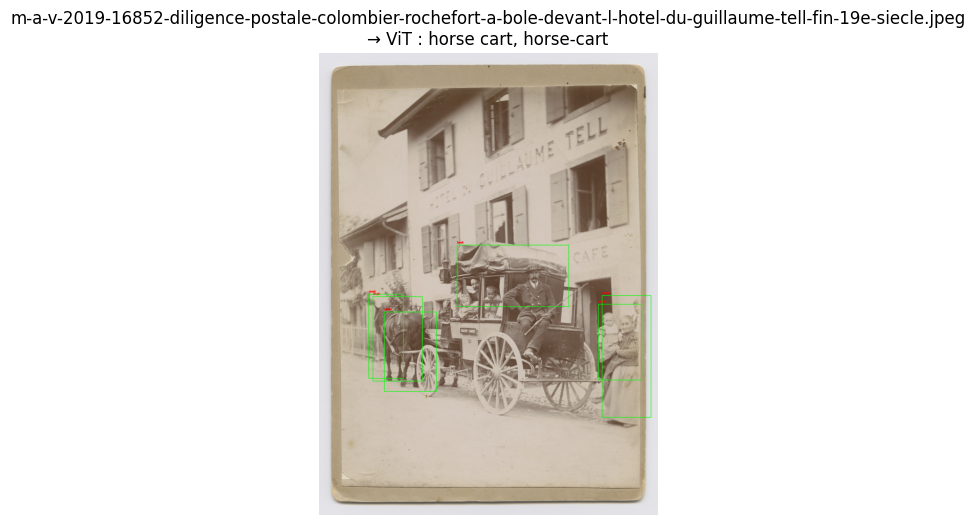

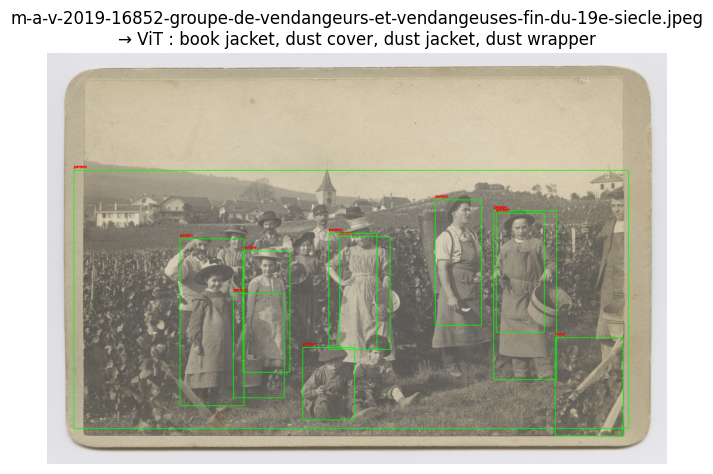

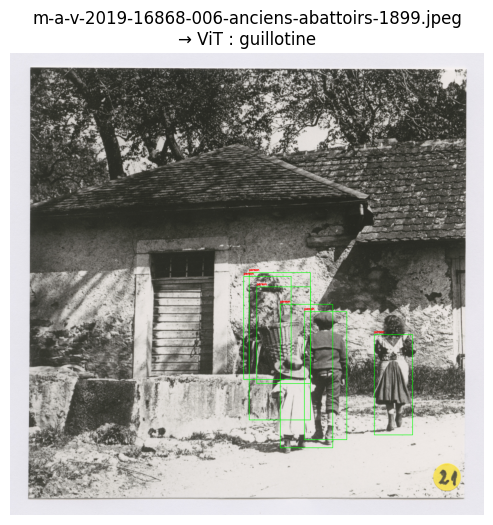

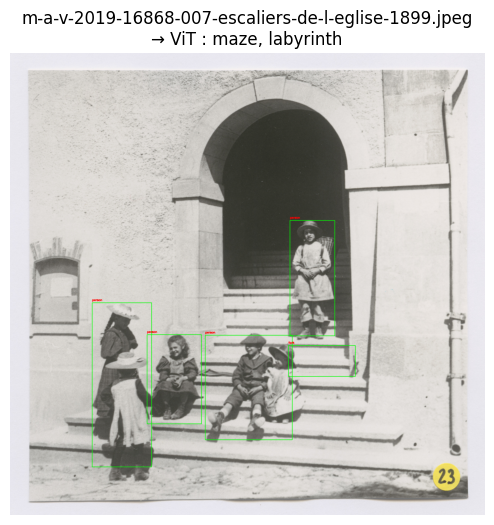

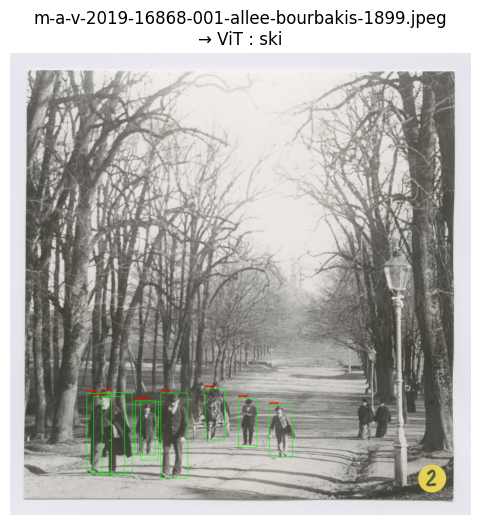

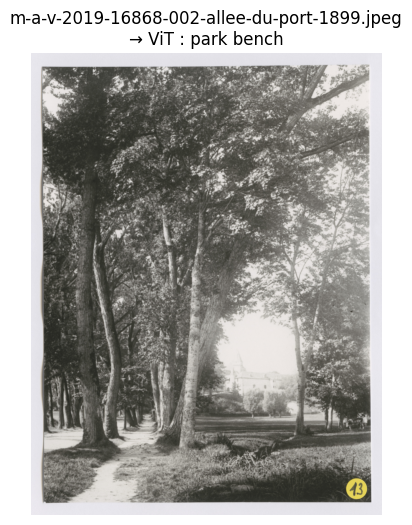

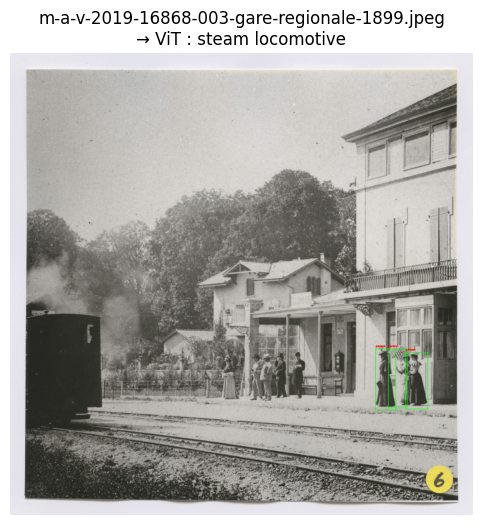

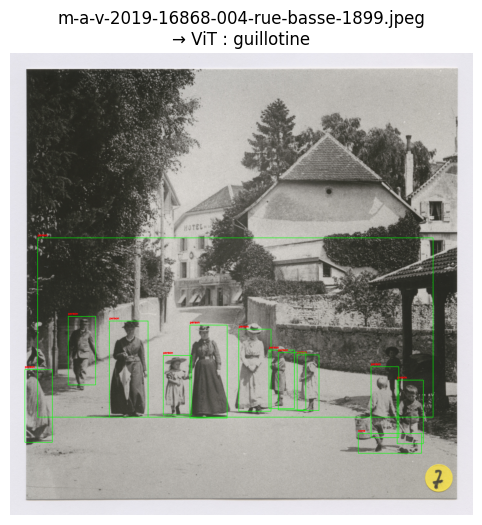

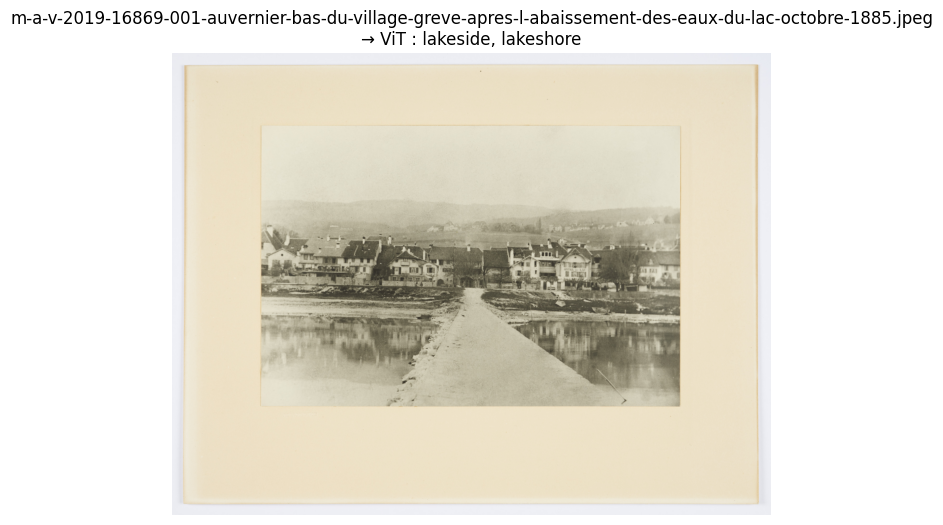

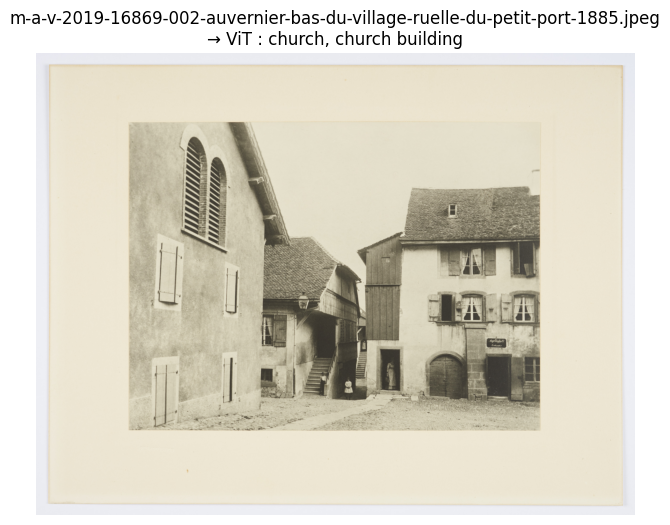

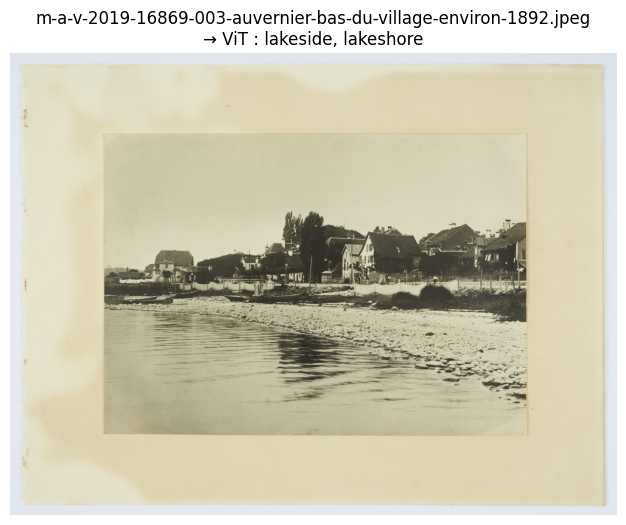

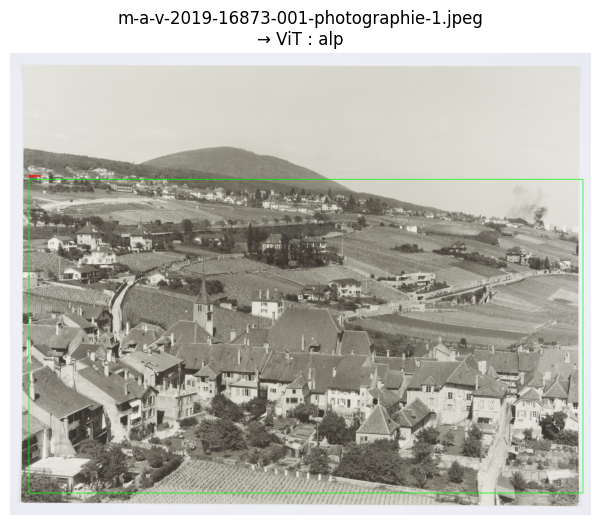

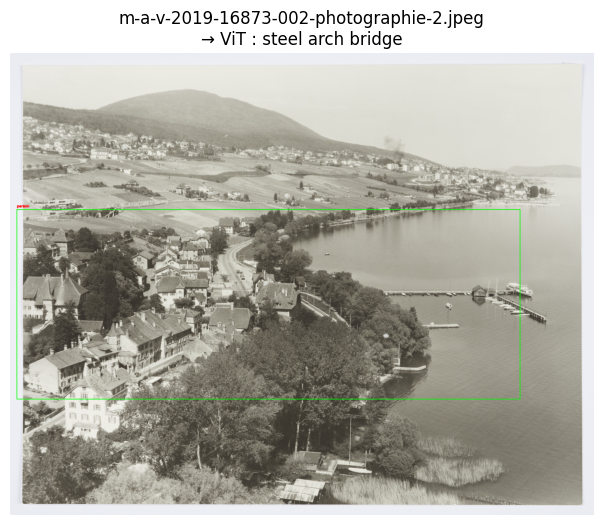

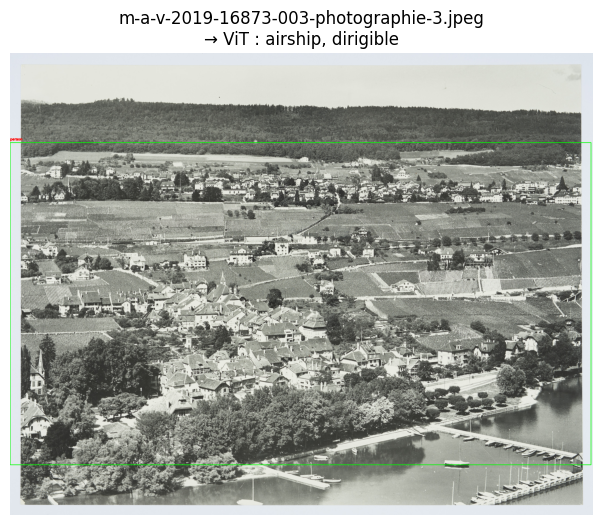

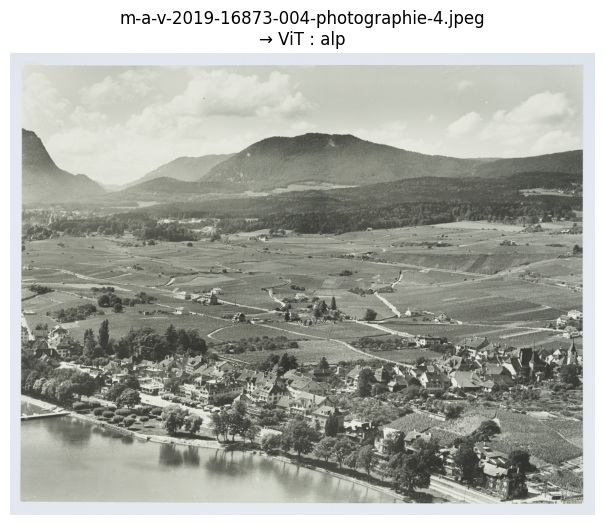

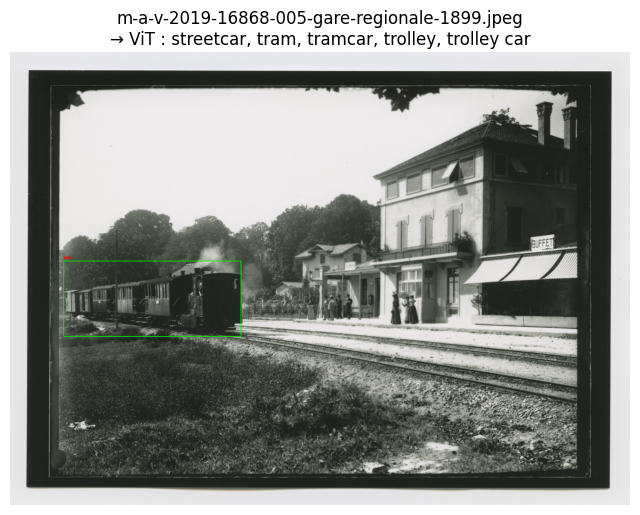

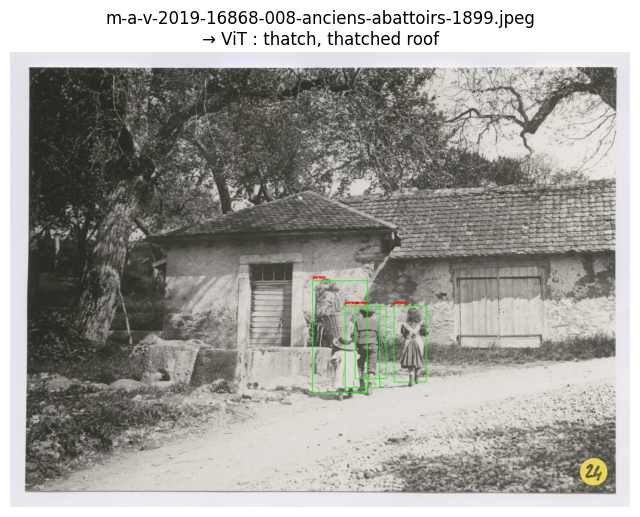

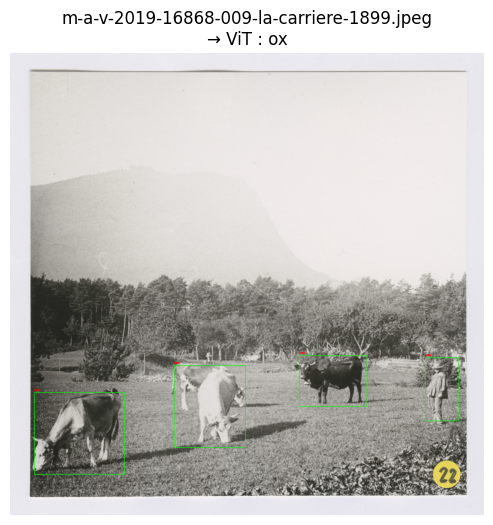

In [ ]:
# Appliquer à toutes les images présentes dans le dossiers "images"
supported_formats = ('.jpg', '.jpeg', '.png', '.bmp')
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(supported_formats)]

print(f"{len(image_files)} images trouvées.")

for image_path in image_files:
    process_image_with_detection_and_classification(image_path)



In [ ]:
# Créer un sous-dossier "Résultat" dans le dossier Drive d'origine
result_folder = os.path.join(folder_path, "Resultat")
os.makedirs(result_folder, exist_ok=True)

# Définir le chemin de sortie du CSV dans ce dossier
csv_output_path = os.path.join(result_folder, "resultats_detection_classification.csv")

# Export du DataFrame en CSV
df_results = pd.DataFrame(results)
df_results.to_csv(csv_output_path, index=False, encoding='utf-8')

print(f"CSV enregistré ici : {csv_output_path}")


CSV enregistré ici : /content/drive/MyDrive/Colab_Notebooks/images/Resultat/resultats_detection_classification.csv


## Résultat

Les résultats appliqués à un fonds d'images anciennes sont mitigés. Le code a parfaitement fonctionné et le traitement de détection et classification a parfaitement été appliqué sur le fonds d'images. Cependant les images utilisées mettent en évidence certaines limitations de cette méthode.

La première provient probablement des images elles-mêmes, il s'agit de JPEG utilisé pour la diffusion sur le web avec une faible résolution. Les modèles se basant sur les pixels de l'image pour détecter les objets, cela influence le résultat final.

Deuxièmement les modèles utilisés ont été entrainés sur des images récentes, cela peut-être observé notamment avec les classes "COCO". Le modèle fonctionnant par inférence peu importe l'image, il y a un taux d'erreur plus important sur des images anciennes. Cela peut être partiellement palié en enlevant des classes. Neanmoins cela réste un biais inhérant à ces modèles.

# Traitement par LLM

In [2]:
# -- Étape 1 : Installer et importer les bibliothèques nécessaires --
!pip install openai pillow --quiet

In [9]:
import base64
import os
import time
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
from PIL import Image, UnidentifiedImageError

In [10]:
# --- Étape 2 : Configuration OpenRouter ---
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="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"  # Remplacez par votre clé OpenRouter généreré sur https://openrouter.ai/meta-llama/llama-4-maverick:free/api
)

In [12]:
# --- Étape 3 : Fonctions utilitaires ---
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

def is_image_valid(image_path):
    try:
        Image.open(image_path).verify()
        return True
    except (UnidentifiedImageError, IOError):
        return False

def query_llama_vision(image_path):
    base64_image = encode_image_to_base64(image_path)

    response = client.chat.completions.create(
        model="meta-llama/llama-4-maverick:free",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                    },
                    {
                        "type": "text",
                        "text": "Vous êtes expert en indexation d'archives photographiques. Votre tâche consiste à effectuer une indexation descriptive de 3 à 5 mots-clés en français pour chaque image. Basez votre analyse uniquement sur le contenu visuel de l'image ; ne formulez aucune hypothèse et n'incluez aucune information supplémentaire. Formulez votre réponse par des mots-clés d'indexation. Exemple : mot-clé1, mot-clé2, mot-clé3. Analysez maintenant l'image fournie et générez les mots-clés d'indexation."
                    }
                ]
            }
        ],
        max_tokens=400
    )
    return response.choices[0].message.content.strip()

def query_llama_vision_with_retry(image_path, retries=3, delay=2):
    for attempt in range(retries):
        try:
            if not is_image_valid(image_path):
                return "[ERROR] Unreadable or corrupted image"
            return query_llama_vision(image_path)
        except Exception as e:
            if attempt < retries - 1:
                print(f"⚠️ Attempt {attempt+1} failed: {e}. Retrying in {delay} sec...")
                time.sleep(delay)
            else:
                return f"[ERROR] {str(e)}"

In [13]:
# --- Étape 4 : Paramètres de chemin ---
folder_path = "/content/drive/MyDrive/Colab_Notebooks/images"
result_folder = "/content/drive/MyDrive/Colab_Notebooks/images/Resultat"
os.makedirs(result_folder, exist_ok=True)

In [14]:
# --- Étape 5 : Liste des fichiers image ---
image_filenames = sorted([
    f for f in os.listdir(folder_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

In [15]:
# --- Étape 6 : Génération des descriptions avec rendu ---
results_llm = []
for filename in tqdm(image_filenames, desc="🔎 Interrogation de LLaMA 4 Vision"):
    image_path = os.path.join(folder_path, filename)
    llm_description = query_llama_vision_with_retry(image_path)
    results_llm.append({
        "filename": filename,
        "llm_description": llm_description
    })
    time.sleep(2)  # Respect des limites d'OpenRouter


🔎 Interrogation de LLaMA 4 Vision: 100%|██████████| 18/18 [03:03<00:00, 10.22s/it]


In [16]:
# Convertir results_llm en DataFrame
df_results = pd.DataFrame(results_llm)

# Afficher le DataFrame
display(df_results)

filename  \
0   m-a-v-2019-16852-diligence-postale-colombier-r...   
1   m-a-v-2019-16852-groupe-de-vendangeurs-et-vend...   
2      m-a-v-2019-16868-001-allee-bourbakis-1899.jpeg   
3        m-a-v-2019-16868-002-allee-du-port-1899.jpeg   
4       m-a-v-2019-16868-003-gare-regionale-1899.jpeg   
5            m-a-v-2019-16868-004-rue-basse-1899.jpeg   
6       m-a-v-2019-16868-005-gare-regionale-1899.jpeg   
7    m-a-v-2019-16868-006-anciens-abattoirs-1899.jpeg   
8   m-a-v-2019-16868-007-escaliers-de-l-eglise-189...   
9    m-a-v-2019-16868-008-anciens-abattoirs-1899.jpeg   
10         m-a-v-2019-16868-009-la-carriere-1899.jpeg   
11  m-a-v-2019-16869-001-auvernier-bas-du-village-...   
12  m-a-v-2019-16869-002-auvernier-bas-du-village-...   
13  m-a-v-2019-16869-003-auvernier-bas-du-village-...   
14           m-a-v-2019-16873-001-photographie-1.jpeg   
15           m-a-v-2019-16873-002-photographie-2.jpeg   
16           m-a-v-2019-16873-003-photographie-3.jpeg   
17           m-a-v-2019-16873-004-photographie-4.jpeg   

                                     llm_description  
0              Voiture, chevaux, diligence, facteur.  
1               Vendange, vigne, vendangeur, enfant.  
2                            allée, arbres, piétons.  
3                       Arbre, chemin, parc, église.  
4    Gare, train, voyageurs, bâtiments, voie ferrée.  
5   famille, rue, village, architecture, XIXe siècle  
6                Gare, chemin de fer, train, buffet.  
7        Maison, enfants, panier, village, campagne.  
8      enfants, architecture, entrée, bâtiment, banc  
9                   Maison, enfants, ferme, village.  
10              Troupeau, vache, pâturage, montagne.  
11             rivière, maisons, quai, village, eau.  
12     Bâtiment, maison, cour, ruelle, architecture.  
13          rivière, maisons, rive, village, barque.  
14          Maison, vignoble, village, architecture.  
15          Village, lac, rivière, maison, montagne.  
16           Bateaux, lac, village, vignes, maisons.  
17                   vignes, lac, village, montagne.

In [17]:
# --- Étape 7 : Sauvegarde dans un CSV ---
csv_output_path = os.path.join(result_folder, "résultats_llm_llama4.csv")
pd.DataFrame(results_llm).to_csv(csv_output_path, index=False, encoding="utf-8")
print(f"✅ Résultats enregistrés dans : {csv_output_path}")

✅ Résultats enregistrés dans : /content/drive/MyDrive/Colab_Notebooks/images/Resultat/résultats_llm_llama4.csv


## Mise en perspectives et conclusion

En conclusion, le fonctionnement du code permettant un traitment par lot, rend la méthode intéressante sur des fonds d'images en archives. De plus le rendu en CSV permet des imports, permettant d'utiliser ces classifications comme methode d'indexation automatique.

## Bibliographie